In [1]:
import simpy
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import itertools
import arrow
import random
import math
import warnings

## Set start date and define it to be equal to the simulation time
This allows monitoring of day-of-week.  

Defined in days: Monday = 0

## MIKE notes  
list of actual times of surgery to see how many could fit in an actual schedule - (scenario) 

efficient use of time ie minimise downtime

ie v simple rule - question it
Find out who the scheduler is and how she schedules

In [2]:
start = arrow.get('2022-06-27')  #start on a monday -- ?more dynamic?
env = simpy.Environment()

In [3]:
#checking - note start a/a not in real time.  Monday=0
current_date = start.shift(days=env.now)  
print('Current weekday:', current_date.weekday())

tomorrow_date = current_date.shift(days=+1)
print('Tomorrow weekday:', tomorrow_date.weekday())


start.shift(days=env.now).weekday()

Current weekday: 0
Tomorrow weekday: 1


0

## Parameters
* Primary: primary hip, primary knee, primary uni-compartmental knee
* Revision: revision hip, revision knee

In [4]:
# ward parameters
primary_hip_mean_los = 10
primary_knee_mean_los = 9
revision_hip_mean_los = 8
revision_knee_mean_los = 7
unicompart_knee_mean_los = 6

primary_hip_sd_los = 3
primary_knee_sd_los = 2
revision_hip_sd_los = 2
revision_knee_sd_los = 3
unicompart_knee_sd_los = 1

delay_post_los_mean = 4
delay_post_los_sd = 3

prob_surgery_on_day = 0.95
prob_ward_delay = 0.2

#Ward resources
number_beds = 40

#patient parameters
#same day cancellations patient reasons
prop_not_cancel_primary = 0.98
prop_not_cancel_revision = 0.99

primary_dict = {1:'p_hip', 2:'p_knee', 3:'uni_knee'}
revision_dict = {1:'r_hip', 2:'r_knee'}
primary_prop = [0.4,0.4,0.2]
revision_prop = [0.6, 0.4]

#theatre resources
number_theatres = 4
primaries_per_day = [1,3,5] #primaries between 1 and 5, revisions dep. upon no. primaries
revisions_per_day = [2,1,0] #adjust for scenario: add extra theatre slot in

# skeleton frame for theatre schedule assuming no surgical activity on weekends
# for weekend activity, change '0' to '1'
schedule_list = {'Day':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                        'Friday', 'Saturday', 'Sunday'],
                'Primary_slots':[1,1,1,1,1,0,0],
                'Revision_slots':[1,1,1,1,1,0,0]}

#simulation parameters
number_of_runs = 3
results_collection_period = 10  #28*6 
warm_up_period =  2
default_rng_set = None 
#results auditing
first_obs = 1
interval = 1

TRACE = True

## TOM NOTES

one long run 10 yrs p159robinson, Banks et al  

sensitivity analysis - los params and distrib (lnorm, gamma, edf) +/- trunc  

outliers, double peak etc  

vary run lengths eg 1mth vs 1 year  

outputs by day and by patient  

2k design, interaction - robinson, tom paper

MORE plots!!!

In [5]:
# later for translation: ignore this - testing

primary_dict = {1:'p_hip', 2:'p_knee', 3:'uni_knee'}
revision_dict = {1:'r_hip', 2:'r_knee'}
primary_prop = np.random.choice(np.arange(1,4), p=[0.4,0.4,0.2])
revision_prop = np.random.choice(np.arange(1,3), p=[0.6, 0.4])

def vec_tran(prop, dict):
    return np.vectorize(dict.__getitem__)(prop)

#trial sample and vectorize by dict key
primary_sample = vec_tran(primary_prop, primary_dict)
print(primary_sample)

print(int(primary_prop))
print(revision_prop)

type(primary_prop)

uni_knee
3
1


numpy.int64

## Trace utility for debugging

In [6]:
def trace(msg):
    if TRACE:
        print(msg)

## Distribution classes for generating LoS and branching
* Used to control random number sampling
* Each distribution has its own stream
* Lognormal for lengths-of-stay
* Bernoulli for determining lost theatres slots and delayed discharges

In [7]:
class Lognormal:
    """for creating LoS distributions for each patient type"""
    def __init__(self, mean, stdv, random_seed = None):
        self.rng = np.random.default_rng(seed = random_seed)
        mu, sigma = self.calc_params(mean, stdv)
        self.mu = mu
        self.sigma = sigma
        
    def calc_params(self, mean, stdv):
        phi = (stdv **2 + mean **2) **0.5
        mu = np.log(mean**2/phi)
        sigma = (np.log(phi **2/mean **2)) **0.5
        return mu, sigma
    
    def sample(self):
        """
        method to generate a sample from the lognormal distribution
        """
        return self.rng.lognormal(self.mu, self.sigma)
        
class Bernoulli:
    """for pathway branching: slots lost on day, 
    patients whose LoS is delayed due to downstream processes
    """
    def __init__(self, p, random_seed = None):
        """p = prob of drawing a 1"""
        self.rng = np.random.default_rng(seed=random_seed)
        self.p = p
      
    def sample(self, size = None):
        """
        method to generate a sample from the Bernoulli distribution
        """
        return self.rng.binomial(n = 1, p = self.p, size = size) 
    
class Gamma:
    """for sensitivity analysis on LoS distributions for each patient type"""
    def __init__(self, mean, stdv, random_seed = None):
        self.rng = np.random.default_rng(seed = random_seed)
        scale, shape = self.calc_params(mean, stdv)
        self.scale = scale
        self.shape = shape
        
    def calc_params(self, mean, stdv):
        scale = (stdv **2) / mean 
        shape = (stdv **2) / (scale **2)
        return scale, shape
    
    def sample(self, size = None):
        """
        method to generate a sample from the gamma distribution
        """
        return self.rng.gamma(self.shape, self.scale, size = size)   

## Theatre schedule

* 4 theatres (2-6)
* 5 day/week (5-7)
* Each theatre has three sessions per day:
        * Morning: 1 revision OR 2 primary
        * Afternoon: 1 revision OR 2 primary
        * Evening: 1 primary
        

In [8]:
def surgery_types(list): 
    """
    Randomly sample surgeries per day given 3* 4-hour sessions/day
    
    Number of revision surgeries depends upon number of primary surgeries
    
    * Each theatre has three sessions per day and some rules:
        * Morning: 1 revision OR 2 primary
        * Afternoon: 1 revision OR 2 primary
        * Evening: 1 primary
    """
    list = primaries_per_day
    select_primaries = random.choice(list)
    if select_primaries == primaries_per_day[0]:
        select_revisions = revisions_per_day[0]
    elif select_primaries == primaries_per_day[1]:
        select_revisions = revisions_per_day[1]
    else: select_revisions = revisions_per_day[2]
    
    return pd.Series([select_primaries, select_revisions])

#sample to illustrate one week, one theatre
schedule_list_sample = pd.DataFrame(schedule_list)
schedule_list_sample[['Primary_slots', 'Revision_slots']] = \
    schedule_list_sample['Primary_slots'].apply(lambda x: x*surgery_types(list))

print(schedule_list_sample)

         Day  Primary_slots  Revision_slots
0     Monday              3               1
1    Tuesday              1               2
2  Wednesday              5               0
3   Thursday              5               0
4     Friday              3               1
5   Saturday              0               0
6     Sunday              0               0


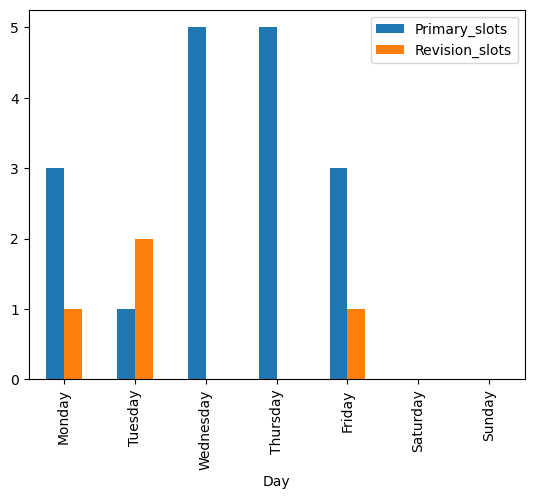

In [9]:
#sample schedule for 1 theatre for 1 week
schedule_list_plot = pd.DataFrame(schedule_list_sample).plot.bar(x ='Day'); 

## Create full theatre schedule for duration of runtime

In [10]:
#theatre slots available for the length of simulation runtime

schedule_list = pd.DataFrame(schedule_list)
schedule_avail = schedule_list.copy() 

length_sched = int(round(2*(warm_up_period+results_collection_period)/7, 0))
schedule_avail = schedule_avail.iloc[np.tile(np.arange(len(schedule_avail)), 
                    length_sched)].reset_index()
schedule_avail_temp = schedule_avail.copy()
schedule_avail_temp2 = schedule_avail.copy()

def theatre_capacity():
    """
    Calculate full theatre capacity schedule for given number of theatres
    Randomly create each theatre's schedule each day according to rules
    Result = 4-20 primary; 0-8 revision per day
    """
    schedule_avail['Primary_slots'].values[:] = 0
    schedule_avail['Revision_slots'].values[:] = 0
    for i in range(number_theatres):
        schedule_avail_temp[['Primary_slots', 'Revision_slots']] = \
            schedule_avail_temp2['Primary_slots'].\
            apply((lambda x: x*surgery_types(primaries_per_day)))
        schedule_avail[['Primary_slots', 'Revision_slots']] += \
            (schedule_avail_temp[['Primary_slots', 'Revision_slots']]) 
    return(schedule_avail)


schedule_avail = theatre_capacity()
schedule_avail.to_csv('data/schedule.csv')
schedule_avail.head(10)

,index,Day,Primary_slots,Revision_slots
0,0,Monday,16,2
1,1,Tuesday,16,2
2,2,Wednesday,14,3
3,3,Thursday,16,2
4,4,Friday,14,3
5,5,Saturday,0,0
6,6,Sunday,0,0
7,0,Monday,14,3
8,1,Tuesday,16,2
9,2,Wednesday,12,4


In [11]:
schedule_utilised = schedule_avail.copy() 
for col in schedule_utilised.columns:
    schedule_utilised['Primary_slots'].values[:] = 0
    schedule_utilised['Revision_slots'].values[:] = 0
schedule_utilised.head()

,index,Day,Primary_slots,Revision_slots
0,0,Monday,0,0
1,1,Tuesday,0,0
2,2,Wednesday,0,0
3,3,Thursday,0,0
4,4,Friday,0,0


In [12]:
#create schedule of utilised slots (losing proportion of patient-reason same-day cancellations) 
#and schedule of available slots (total capacity available)
#row
t = 0 
weekday = current_date.weekday()

#columns
slot_primary, slot_revision = 2,3

schedule_utilised.iat[t, slot_primary] += schedule_avail.iat[t, slot_primary]
schedule_utilised.iat[t, slot_revision] += schedule_avail.iat[t, slot_revision]


#generated theatre schedule - total available slots
#schedule_avail.iat[t, slot_primary] -= schedule_avail.iat[t, slot_primary] #####  ? remove prop'n same day lost slots here ?? check with Tom B. re data.
#schedule_avail.iat[t, slot_revision] -= schedule_avail.iat[t, slot_revision] ## a/a

print(len(schedule_utilised))

217


In [13]:
#####  same-day cancellations patient reasons --- leave for now but may be a better way of doing this -- 

schedule_utilised['Primary_prop'] = round((prop_not_cancel_primary**schedule_utilised["Primary_slots"])\
                                          *schedule_utilised["Primary_slots"])
schedule_utilised['Revision_prop'] = round((prop_not_cancel_revision**schedule_utilised["Revision_slots"])\
                                           *schedule_utilised["Revision_slots"])
schedule_utilised.head()


,index,Day,Primary_slots,Revision_slots,Primary_prop,Revision_prop
0,0,Monday,16,2,12.0,2.0
1,1,Tuesday,0,0,0.0,0.0
2,2,Wednesday,0,0,0.0,0.0
3,3,Thursday,0,0,0.0,0.0
4,4,Friday,0,0,0.0,0.0


In [14]:
schedule_avail.head()  



##### 
# at time t, let in primary and revisions in schedule_booked, randomly allocated to patient type.
# before letting them in, sample out proportion of lost slots.
# Then if any in q (ie no bed capacity), let them out == same day cancellations

,index,Day,Primary_slots,Revision_slots
0,0,Monday,16,2
1,1,Tuesday,16,2
2,2,Wednesday,14,3
3,3,Thursday,16,2
4,4,Friday,14,3


In [15]:
schedule_utilised.head()

,index,Day,Primary_slots,Revision_slots,Primary_prop,Revision_prop
0,0,Monday,16,2,12.0,2.0
1,1,Tuesday,0,0,0.0,0.0
2,2,Wednesday,0,0,0.0,0.0
3,3,Thursday,0,0,0.0,0.0
4,4,Friday,0,0,0.0,0.0


## Scenarios class 

In [173]:
class Scenario:
    """
    Holds LoS dists for each patient type
    Holds delay dists
    Holds prob of delay, prob of same day dist
    Holds resources: beds
    Passed to hospital model and process classes
    """
    def __init__(self, random_number_set=default_rng_set):
        """
        controls initial seeds of each RNS used in model
        """
        self.random_number_set = random_number_set
        self.init_sampling()
        self.init_resource_counts()
        
    def set_random_no_set(self, random_number_set):
        """
        controls random sampling for each distribution used in simulations"""
        self.random_number_set = random_number_set
        self.init_sampling()
        
    def init_resource_counts(self):
        """only one resource in the model: beds"""
        self.n_beds = number_beds
        
    def init_sampling(self):
        """
        distribs used in model and initialise seed"""
        rng_streams = np.random.default_rng(self.random_number_set)
        self.seeds = rng_streams.integers(0,99999999999, size = 20)
        
        #######  Distributions ########
        
        # LoS distribution for each surgery patient type
        self.primary_hip_dist = Lognormal(primary_hip_mean_los, primary_hip_sd_los,
                                          random_seed=self.seeds[0])
        self.primary_knee_dist = Lognormal(primary_knee_mean_los, primary_knee_sd_los,
                                          random_seed=self.seeds[1])
        self.revision_hip_dist = Lognormal(revision_hip_mean_los, revision_hip_sd_los,
                                          random_seed=self.seeds[2])
        self.revision_knee_dist = Lognormal(revision_knee_mean_los, revision_knee_sd_los,
                                          random_seed=self.seeds[3])
        self.unicompart_knee_dist = Lognormal(unicompart_knee_mean_los, unicompart_knee_sd_los,
                                          random_seed=self.seeds[4])
        
        # distribution for delayed LoS
        self.los_delay_dist = Lognormal(delay_post_los_mean, delay_post_los_sd,
                                       random_seed=self.seeds[5])
        
        # probability of no same day cancellations 
        self.prob_surgery_occurring = Bernoulli(prob_surgery_on_day, random_seed=self.seeds[6])
        
        #probability of having LoS delayed on ward
        self.los_delay = Bernoulli(prob_ward_delay, random_seed=self.seeds[7])
        
    def number_slots(self, schedule_avail):
        """
        convert to np arrays for each surgery type
        """
        self.schedule_avail_primary = schedule_avail['Primary_slots'].to_numpy()
        self.schedule_avail_revision = schedule_avail['Revision_slots'].to_numpy()
        return(self.schedule_avail_primary, self.schedule_avail_revision)

    # select primary surgical type from custom dist- SHOULDN'T BE HARD-CODED
    def primary_types(self):
        self.primary_surgery = np.random.choice(np.arange(1,4), p=[0.4,0.4,0.2])
        return(self.primary_surgery)
    
    #select revision surgical type from custom dist
    def revision_types(self):
        self.revision_surgery = np.random.choice(np.arange(1,3), p=[0.6,0.4])
        return(self.revision_surgery)
     
    def label_types(self, prop, dict): 
        """
        returns label for each surgery type
        """
        return np.vectorize(dict.__getitem__)(prop)

## Set up process to get started: patient pathways
Patient journeys for primary and revision patients




In [410]:
class PrimaryPatient:
    """
    The process a patient needing primary hip or knee surgery will undergo
    from scheduled admission for surgery to discharge
    
    args: Scenario parameter class
    """
    def __init__(self, day, id, env, args):
        
        self.day = day
        self.id = id
        self.env = env
        self.args = args
        
        self.arrival = -np.inf
        self.queue_beds = -np.inf
        self.primary_los = 0
        self.total_time = -np.inf
        self.depart = -np.inf
        
        self.lost_slots_bool = False
        self.delayed_los_bool = False
        
    def service(self):
        """
        Arrive according to theatres schedule
        Some patients will leave on day of surgery and the slot is lost
        Some patients will have their surgery cancelled due to lack of beds
        Otherwise, patient is admitted and stays in a bed
        Some patients will have a post-bed request delay to their LoS
        Patient is discharged
        """
        
        self.arrival = self.env.now
        self.patient_class = 'primary'
        
        # set los for primary surgery types
        self.types = int(self.args.primary_types())
        if self.types == 1:
            self.primary_los = self.args.primary_hip_dist.sample()
            self.primary_label = 'p_hip'
        elif self.types == 2:
            self.primary_los = self.args.primary_knee_dist.sample()
            self.primary_label = 'p_knee'
        else: 
            self.primary_los = self.args.unicompart_knee_dist.sample()
            self.primary_label = 'uni_knee'

        #vectorize according to dict key to get surgical type
        #self.primary_label = self.args.label_types(primary_prop, primary_dict)   
            
        #sample if need for delayed discharge
        self.need_for_los_delay = self.args.los_delay.sample()
        
        #Patients who have a delayed discharge follow this pathway
        if self.need_for_los_delay:
            
            #request a bed on ward - if none available within 0-0.25 day, patient has surgery cancelled
            with self.args.beds.request() as req:
                
                admission = random.uniform(0,0.25)
                admit = yield req | self.env.timeout(admission)

                if req in admit:
                    """record queue time for primary patients -- if > admission, 
                    this patient will leave the system and the slot is lost"""
                    
                    self.queue_beds = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}' 
                          f'has been allocated a bed at {self.env.now:.3f}' 
                          f'and queued for {self.queue_beds:.3f}')
                    
                    self.primary_los = self.primary_los + args.los_delay_dist.sample()
                    yield self.env.timeout(self.primary_los)
                    self.lost_slots_bool = False
                    self.delayed_los_bool = True
                    self.depart = self.env.now
                    trace(f'los of primary patient {self.id} completed at {self.env.now:.3f}')
                    self.total_time = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'total los = {self.total_time:.3f} with delayed discharge')
                else:
                    #patient had to leave as no beds were available on ward
                    self.no_bed_cancellation = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'had surgery cancelled after {self.no_bed_cancellation:.3f}')
                    self.queue_beds = self.env.now - self.arrival
                    self.total_time = self.env.now - self.arrival
                    self.primary_los = 0
                    self.lost_slots_bool = True
                    self.delayed_los_bool = False
                    self.depart = self.env.now
                    trace(f'primary patient {self.id} {self.primary_label}' 
                          f'recorded {self.lost_slots_bool}')
        #no delayed los
        else:
            #request a bed on ward - if none available within 0 - 0.25 day, patient has surgery cancelled
            with self.args.beds.request() as req:
                admission = random.uniform(0,0.25)
                admit = yield req | self.env.timeout(admission)
                self.no_bed_cancellation = self.env.now - self.arrival

                if req in admit:
                    #record queue time for primary patients -- if >1, this patient will leave the system and the slot is lost
                    self.queue_beds = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'has been allocated a bed at {self.env.now:.3f}'
                          f'and queued for {self.queue_beds:.3f}')

                    self.primary_los = self.primary_los
                    yield self.env.timeout(self.primary_los)
                    self.lost_slots_bool = False
                    self.delayed_los_bool = False
                    self.depart = self.env.now
                    trace(f'los of primary patient {self.id} {self.primary_label}'
                          f'completed at {self.env.now:.3f}')
                    self.total_time = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'total los = {self.total_time:.3f}')
                    
                else:
                    #patient had to leave as no beds were available on ward
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'had surgery cancelled after {self.no_bed_cancellation:.3f}')
                    self.queue_beds = self.env.now - self.arrival
                    self.total_time = self.env.now - self.arrival
                    self.primary_los = 0
                    self.lost_slots_bool = True
                    self.delayed_los_bool = False
                    self.depart = self.env.now
                    trace(f'primary patient {self.id} {self.primary_label}' 
                          f'recorded {self.lost_slots_bool}')
    
class RevisionPatient:
    def __init__(self, day, id, env, args):
        
        self.day = day
        self.id = id
        self.env = env
        self.args = args
        
        self.arrival = -np.inf
        self.queue_beds = -np.inf
        self.revision_los = 0
        self.total_time = -np.inf
        self.depart = -np.inf
        
        self.lost_slots_bool = False
        self.delayed_los_bool = False
        
        
    def service(self):
        """
        Arrive according to theatres schedule
        Some patients will leave on day of surgery and the slot is lost
        Some patients will have their surgery cancelled due to lack of beds
        Otherwise, patient is admitted and stays in a bed
        Some patients will have a post-bed request delay to their LoS
        Patient is discharged
        """
     
        self.arrival = self.env.now
        self.patient_class = 'revision'
        
        # set los for revision surgery types
        self.types = int(self.args.revision_types())
        if self.types == 1:
            self.revision_los = self.args.revision_hip_dist.sample()
            self.revision_label = 'r_hip'
        else: 
            self.revision_los = self.args.revision_knee_dist.sample()
            self.revision_label = 'r_knee'
            
        #vectorize according to dict key to get surgical type
        #self.revision_label = self.args.label_types(revision_prop, revision_dict) 
        
        #sample if need for delayed discharge
        self.need_for_los_delay = self.args.los_delay.sample()
        
        if self.need_for_los_delay:    
        
        #request bed on ward - if none available within 0-0.25 day, patient has surgery cancelled
            with self.args.beds.request() as req:
                admission = random.uniform(0,0.25)
                admit = yield req | self.env.timeout(admission)

                if req in admit:
                    #record queue time for primary patients -- if >admission, this patient will leave the system and the slot is lost
                    self.queue_beds = self.env.now - self.arrival
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'has been allocated a bed at {self.env.now:.3f}'
                          f'and queued for {self.queue_beds:.3f}')
                   
                    self.revision_los = self.revision_los + args.los_delay_dist.sample()
                    yield self.env.timeout(self.revision_los)
                    self.lost_slots_bool = False
                    self.delayed_los_bool = True
                    self.depart = self.env.now
                    trace(f'los of revision patient {self.id} {self.revision_label}'
                          f'completed at {self.env.now:.3f}')
                    self.total_time = self.env.now - self.arrival
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'total los = {self.total_time:.3f} with delayed discharge')

                else:
                    #patient had to leave as no beds were available on ward
                    self.no_bed_cancellation = self.env.now - self.arrival
                    trace(f'revision patient {self.id}'
                          f'had surgery cancelled after {self.no_bed_cancellation:.3f}')
                    self.queue_beds = self.env.now - self.arrival
                    self.total_time = self.env.now - self.arrival
                    self.revision_los = 0
                    self.lost_slots_bool = True
                    self.delayed_los_bool = False
                    self.depart = self.env.now
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'recorded {self.lost_slots_bool}')

        #no need for delayed discharge            
        else:
            #request bed on ward - if none available within 0-1 day, patient has surgery cancelled
            with self.args.beds.request() as req:
                admission = random.uniform(0,0.25)
                admit = yield req | self.env.timeout(admission)
                self.no_bed_cancellation = self.env.now - self.arrival

                if req in admit:
                    #record queue time for primary patients -- if >1, this patient will leave the system and the slot is lost
                    self.queue_beds = self.env.now - self.arrival
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'has been allocated a bed at {self.env.now:.3f}'
                          f'and queued for {self.queue_beds:.3f}')
                    self.revision_los = self.revision_los
                    yield self.env.timeout(self.revision_los)
                    self.lost_slots_bool = False
                    self.delayed_los_bool = False
                    self.depart = self.env.now

                    trace(f'los of revision patient {self.id} completed at {self.env.now:.3f}')
                    self.total_time = self.env.now - self.arrival
                    trace(f'revision patient {self.id} total los = {self.total_time:.3f}')

                else:
                    #patient had to leave as no beds were available on ward
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'had surgery cancelled after {self.no_bed_cancellation:.3f}')
                    self.queue_beds = self.env.now - self.arrival
                    self.total_time = self.env.now - self.arrival
                    self.revision_los = 0
                    self.lost_slots_bool = True
                    self.delayed_los_bool = False
                    self.depart = self.env.now 
                    trace(f'revision patient {self.id} {self.revision_label}' 
                          f'recorded {self.lost_slots_bool}')

    

## Monitor lost slots, beds occupied and throughput by day


In [411]:
class Hospital:
    """
    The orthopaedic hospital model
    """
    def __init__(self, args):
        self.env = simpy.Environment()
        self.args = args
        self.init_resources()
        
        #patient generator lists
        self.patients = []
        self.primary_patients = []
        self.revision_patients = []
        self.primary_patients_id = []
        self.revision_patients_id = []
        self.cum_primary_patients = []
        self.cum_revision_patients = []
               
        self.results_collection_period = None
        self.summary_results = None
        self.audit_interval = 1
        
        self.audit_time = []
        self.audit_day_of_week = []  
        self.audit_beds_used = []
        self.audit_primary_arrival = []
        self.audit_revision_arrival = []
        self.audit_primary_queue_beds = []
        self.audit_revision_queue_beds = []
        self.audit_primary_los = []
        self.audit_revision_los = []

        self.results = pd.DataFrame()
       
    def audit_frame(self):
        
        self.results = pd.DataFrame({'sim_time':self.audit_time,
                                     'weekday': self.audit_day_of_week,
                                     'bed_utilisation': self.audit_beds_used,
                                     'primary_arrivals': self.audit_primary_arrival,
                                     'revision_arrivals': self.audit_revision_arrival,
                                     'primary_bed_queue': self.audit_primary_queue_beds,
                                     'revision_bed_queue': self.audit_revision_queue_beds,
                                     'primary_mean_los': self.audit_primary_los,
                                     'revision_mean_los': self.audit_revision_los})

    def patient_results(self):
        """
        Dataframes to hold individual results per patient per day per run
        """
        
        results_primary_pt = pd.DataFrame({'Day':np.array([getattr(p, 'day') for p in self.cum_primary_patients]),
                             'ID':np.array([getattr(p, 'id') for p in self.cum_primary_patients]),
                             'arrival time':np.array([getattr(p, 'arrival') for p in self.cum_primary_patients]),
                             'patient class':np.array([getattr(p, 'patient_class') for p in self.cum_primary_patients]),
                             'surgery type':np.array([getattr(p, 'primary_label') for p in self.cum_primary_patients]),
                             'lost slots':np.array([getattr(p, 'lost_slots_bool') for p in self.cum_primary_patients]),
                             'queue time':np.array([getattr(p, 'queue_beds') for p in self.cum_primary_patients]),
                             'los':np.array([getattr(p, 'primary_los') for p in self.cum_primary_patients]),
                             'delayed discharge':np.array([getattr(p, 'delayed_los_bool') for p in self.cum_primary_patients]),
                             'depart':np.array([getattr(p, 'depart') for p in self.cum_primary_patients])
                            })
    
        results_revision_pt = pd.DataFrame({'Day':np.array([getattr(p, 'day') for p in self.cum_revision_patients]),
                             'ID':np.array([getattr(p, 'id') for p in self.cum_revision_patients]),
                             'arrival time':np.array([getattr(p, 'arrival') for p in self.cum_revision_patients]),
                             'patient class':np.array([getattr(p, 'patient_class') for p in self.cum_revision_patients]),
                             'surgery type':np.array([getattr(p, 'revision_label') for p in self.cum_revision_patients]),
                             'lost slots':np.array([getattr(p, 'lost_slots_bool') for p in self.cum_revision_patients]),
                             'queue time':np.array([getattr(p, 'queue_beds') for p in self.cum_revision_patients]),
                             'los':np.array([getattr(p, 'revision_los') for p in self.cum_revision_patients]),
                             'delayed discharge':np.array([getattr(p, 'delayed_los_bool') for p in self.cum_revision_patients]),
                             'depart':np.array([getattr(p, 'depart') for p in self.cum_revision_patients])
                            })
        return(results_primary_pt, results_revision_pt)
        
    def plots(self):
        """
        plot results at end of run
        """
    def perform_audit(self):
        """
        Results per day
        monitor ED each day and return daily results for metrics in audit_frame
        """
        yield self.env.timeout(warm_up_period)
        
        while True:
            #simulation time
            t = self.env.now
            self.audit_time.append(t)
            
            #weekday
            self.audit_day_of_week.append(start.shift(days=self.env.now -1).weekday())
            
            ##########  bed utilisation
            (self.audit_beds_used.append(self.args.beds.count / self.args.n_beds))
            
            ###########  lost slots
            patients = self.cum_revision_patients + self.cum_primary_patients
            
            # deal with lost slots on zero arrival days
            """
            lost_slots = []
            def zero_days(ls):
                if not zero_days:
                    return 1
                else:
                    return 0
 
            ls = (np.array([getattr(p, 'lost_slots_int') for p in patients]))
            if zero_days(ls):
                lost_slots = 0
            else:
            """
            #lost_slots = len(np.array([getattr(p,'lost_slots_int') for p in patients / len(patients)

            #self.audit_slots_lost.append(lost_slots)
            
            ######### arrivals
            pp = len(np.array([p.id for p in self.cum_primary_patients]))
            rp = len(np.array([p.id for p in self.cum_revision_patients]))
            self.audit_primary_arrival.append(len(self.primary_patients))
            self.audit_revision_arrival.append(len(self.revision_patients))
                                               
            #queue times
            primary_q = np.array([getattr(p, 'queue_beds') for p in self.cum_primary_patients
                                           if getattr(p, 'queue_beds') > -np.inf]).mean()
            self.audit_primary_queue_beds.append(primary_q)
                                               
            revision_q = np.array([getattr(p, 'queue_beds') for p in self.cum_revision_patients
                                           if getattr(p, 'queue_beds') > -np.inf]).mean()
            self.audit_revision_queue_beds.append(revision_q)
                                               
            #mean lengths of stay
            primarylos = np.array([getattr(p, 'primary_los') for p in self.cum_primary_patients
                                           if getattr(p, 'primary_los') > -np.inf]).mean().round(2)
            self.audit_primary_los.append(primarylos)
                                               
            revisionlos = np.array([getattr(p, 'revision_los') for p in self.cum_revision_patients
                                           if getattr(p, 'revision_los') > -np.inf]).mean().round(2)
            self.audit_revision_los.append(revisionlos)
            
            yield self.env.timeout(self.audit_interval)

    def init_resources(self):
        """
        ward beds initialised and stored in args
        """
        self.args.beds = simpy.Resource(self.env, 
                                        capacity=self.args.n_beds)
        
    def run(self, results_collection = results_collection_period+warm_up_period):
        """
        single run of model
        """
        self.env.process(self.patient_arrivals_generator_primary())
        self.env.process(self.patient_arrivals_generator_revision())
        self.env.process(self.perform_audit())
        self.results_collection = results_collection
        self.env.run(until=results_collection)
        audit_frame = self.audit_frame()
        return audit_frame
    
    def patient_arrivals_generator_primary(self):
        """
        Primary patients arrive according to daily theatre schedule
        ------------------
        """
        sched = args.number_slots(schedule_avail)[0]
        pt_count = 1
        for day in range(len(sched)):
            
            primary_arrivals = sched[day]
            trace(f'--------- {primary_arrivals} primary patients are scheduled on Day {day} -------')
            for i in range(primary_arrivals):
                
                    new_primary_patient = PrimaryPatient(day, pt_count, self.env, self.args)
                    self.cum_primary_patients.append(new_primary_patient)
                    self.primary_patients.append(new_primary_patient)
                    #for debuggng
                    self.primary_patients_id.append(new_primary_patient.id)
                    trace(f'primary patient {pt_count} arrived on day {day:.3f}')
                    self.env.process(new_primary_patient.service())
                    pt_count += 1
                    trace(f'primary ids: {self.primary_patients_id}')
            yield self.env.timeout(1)
            self.primary_patients *= 0
                    
            
    def patient_arrivals_generator_revision(self):
        """
        Revision patients arrive according to daily theatre schedule
        ------------------
        """
            
        sched = args.number_slots(schedule_avail)[1]
        pt_count = 1
        for day in range(len(sched)):
            
            revision_arrivals = sched[day]
            trace(f'--------- {revision_arrivals} revision patients are scheduled on Day {day} -------')
            for i in range(revision_arrivals):
                    new_revision_patient = RevisionPatient(day, pt_count, self.env, self.args)
                    self.cum_revision_patients.append(new_revision_patient)
                    self.revision_patients.append(new_revision_patient)
                    #for debugging
                    self.revision_patients_id.append(new_revision_patient.id)
                    trace(f'revision patient {pt_count} arrived on day {day:.3f}')
                    self.env.process(new_revision_patient.service())
                    pt_count += 1
                    trace(f'revision ids: {self.revision_patients_id}')
            yield self.env.timeout(1)
            self.revision_patients *= 0
                    
                    

## Summary results across days and runs

In [412]:
class Summary:
    """
    summary results across single run
    """
    def __init__(self, model):
        """ model: Hospital """
        
        self.model = model
        self.args = model.args
        self.summary_results = None
        
    def process_run_results(self):
        self.summary_results = {}
        
        #all patients arrived
        patients = self.model.cum_primary_patients + self.model.cum_revision_patients
        
        #throughput
        primary_throughput = len([p for p in self.model.cum_primary_patients if p.total_time > -np.inf])
        revision_throughput = len([p for p in self.model.cum_revision_patients if p.total_time > -np.inf])
        
        #mean queues - this also includes patients who renege and therefore have 0 queue
        mean_primary_queue_beds = np.array([getattr(p, 'queue_beds') for p in self.model.cum_primary_patients
                                           if getattr(p, 'queue_beds') > -np.inf]).mean()
        mean_revision_queue_beds = np.array([getattr(p, 'queue_beds') for p in self.model.cum_revision_patients
                                           if getattr(p, 'queue_beds') > -np.inf]).mean()
        
        #check mean los
        mean_primary_los = np.array([getattr(p, 'primary_los') for p in self.model.cum_primary_patients
                                           if getattr(p, 'primary_los') > -np.inf]).mean()
        mean_revision_los = np.array([getattr(p, 'revision_los') for p in self.model.cum_revision_patients
                                           if getattr(p, 'revision_los') > -np.inf]).mean()
        
        ##############check these#############

        mean_primary_bed_utilisation = np.array([p.primary_los for p in self.model.cum_primary_patients]).sum() / (results_collection_period * number_beds)
        mean_revision_bed_utilisation = np.array([p.revision_los for p in self.model.cum_revision_patients]).sum() / (results_collection_period * number_beds)
        
        self.summary_results = {'arrivals':len(patients),
                                'primary_arrivals':len(self.model.primary_patients_id),  
                                'revision_arrivals':len(self.model.revision_patients_id),                     
                                'primary_throughput':primary_throughput,
                                'revision_throughput':revision_throughput,
                                'primary_queue':mean_primary_queue_beds,
                                'revision_queue':mean_revision_queue_beds,
                                'mean_primary_los':mean_primary_los,
                                'mean_revision_los':mean_revision_los,
                                'primary_bed_utilisation':mean_primary_bed_utilisation,
                                'revision_bed_utilisation':mean_revision_bed_utilisation}
    
    def summary_frame(self):
        if self.summary_results is None:
            self.process_run_results()
        df = pd.DataFrame({'1':self.summary_results})
        df = df.T
        df.index.name = 'rep'
        return df
                                            

## Functions for running the model and collecting the results

In [413]:
def single_run(scenario, results_collection=results_collection_period+warm_up_period, random_no_set=default_rng_set):
    """
    summary results for a single run which can be called for multiple runs
    """
    scenario.set_random_no_set(random_no_set)
    model = Hospital(scenario)
    model.run(results_collection = results_collection)
    summary = Summary(model)
    
    #summary results for a single run
    summary_df = summary.summary_frame()
    
    #summary per day results for a single run
    results_per_day = model.results
    
    #patient-level results
    patient_results = model.patient_results()
    
    return(summary_df, results_per_day, patient_results)

def multiple_reps(scenario, results_collection=results_collection_period+warm_up_period, n_reps=number_of_runs):
    """
    create dataframes of summary results across multiple runs:
    1. summary table per run
    2. summary table per run and per day
    3a. primary patient results for all days and all runs 
    3b. revision patient results for all days and all runs
    """
    #summary per run for multiple reps
    results = [single_run(scenario, results_collection, random_no_set=rep)[0]
                         for rep in range(n_reps)]
    df_results = pd.concat(results)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    
    #summary per day per run for multiple reps
    day_results = [single_run(scenario, results_collection, random_no_set=rep)[1]
                         for rep in range(n_reps)]
    
    length_run = [*range(1, results_collection-warm_up_period+1)]
    length_reps = [*range(1, n_reps+1)]
    run = [rep for rep in length_reps for i in length_run]
    
    df_day_results = pd.concat(day_results)
    df_day_results['run'] = run
    
    #patient results for all days and all runs
    primary_pt_results = [single_run(scenario, results_collection, random_no_set=rep)[2][0]
                         for rep in range(n_reps)]
    primary_pt_results = pd.concat(primary_pt_results)
    revision_pt_results = [single_run(scenario, results_collection, random_no_set=rep)[2][1]
                         for rep in range(n_reps)]
    revision_pt_results = pd.concat(revision_pt_results)

    return (df_results, df_day_results, primary_pt_results, revision_pt_results)

## A single run

In [414]:
# a single run
args = Scenario()
s_results = single_run(args, random_no_set = 42)
print(repr(s_results[0].T))
print(repr(s_results[1].head()))
print(repr(s_results[2][0].head()))
print(repr(s_results[2][1].head()))

rep                                 1
arrivals                  1234.000000
mean_primary_los             4.258753
mean_revision_los            0.690049
primary_arrivals           928.000000
primary_bed_utilisation      0.988031
primary_queue                0.072894
primary_throughput         893.000000
revision_arrivals          306.000000
revision_bed_utilisation     0.052789
revision_queue               0.116133
revision_throughput        305.000000
   sim_time  weekday  bed_utilisation  primary_arrivals  revision_arrivals  \
0         7        6            0.875                 0                  0   
1         8        0            0.900                14                  3   
2         9        1            0.825                16                  2   
3        10        2            0.925                12                  4   
4        11        3            0.925                16                  2   

   primary_bed_queue  revision_bed_queue  primary_mean_los  revision_mean_l

## Multiple runs

In [1]:
%%time
args = Scenario()
m_results = multiple_reps(args, n_reps=number_of_runs)[0]
m_day_results = multiple_reps(args, n_reps=number_of_runs)[1]
m_primary_pt_results = multiple_reps(args, n_reps=number_of_runs)[2]
m_revision_pt_results = multiple_reps(args, n_reps=number_of_runs)[2]
  
pt_results = pd.concat([m_primary_pt_results, m_revision_pt_results])

m_day_results.to_csv('data/day_results.csv')
m_primary_pt_results.to_csv('data/primary_patient_results.csv')
m_revision_pt_results.to_csv('data/revision_patient_results.csv')

print(repr(m_results.head(3)))
print(repr(m_day_results.head(3)))
print(repr(pt_results[0].head(3)))
print(repr(pt_results[1].head(3)))

NameError: name 'Scenario' is not defined

## summary results for multiple runs

In [155]:
#summary results for multiple runs
m_results.mean().round(2)

arrivals                    1234.00
lost_slots                    52.68
mean_primary_los               9.14
mean_revision_los              7.74
primary_arrivals             928.00
primary_bed_utilisation        2.12
primary_queue                  0.01
primary_throughput           376.10
revision_arrivals            306.00
revision_bed_utilisation       0.59
revision_queue                 0.06
revision_throughput           24.10
dtype: float64

# summary results per day for multiple runs  

## Group by simulation time

In [156]:
m_day_results_ts = m_day_results.groupby(['sim_time']).mean()
m_day_results_ts.head()

,weekday,bed_utilisation,primary_arrivals,revision_arrivals,primary_bed_queue,revision_bed_queue,primary_mean_los,revision_mean_los,run
sim_time,,,,,,,,,
7,6.0,0.8350,0.0,0.0,0.000444,0.0,9.276,8.010,5.5
8,0.0,0.8975,14.0,3.0,0.002016,0.0,9.294,7.946,5.5
9,1.0,0.9000,16.0,2.0,0.004873,0.0,9.269,7.858,5.5
10,2.0,0.9000,12.0,4.0,0.006832,0.0,9.248,7.809,5.5
11,3.0,0.9350,16.0,2.0,0.007907,0.0,9.182,7.779,5.5


Text(0.5, 1.0, 'Bed Utilisation across model runtime (175 days')

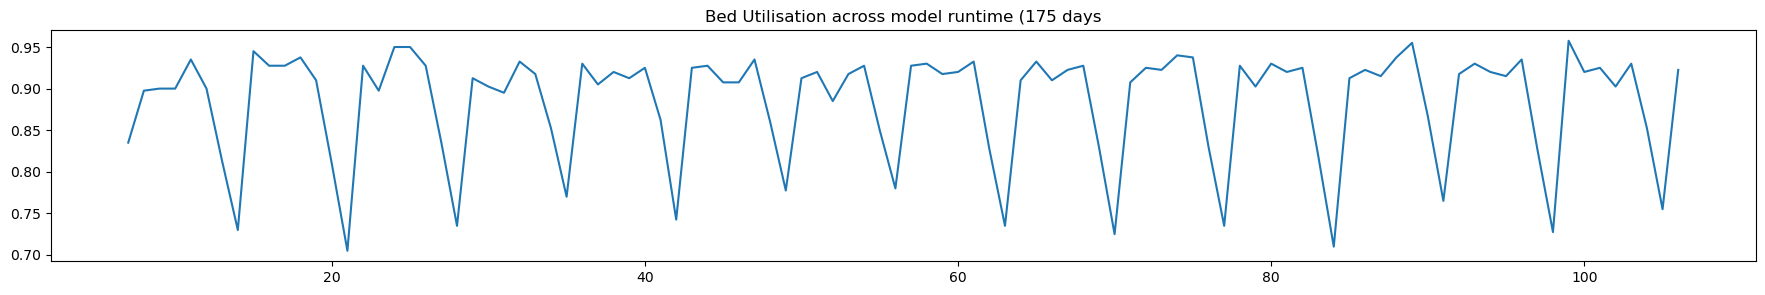

In [157]:
fig = plt.figure(figsize=(22,3))
ax = fig.add_subplot()

# using indexing to select gronigen and the daily number of cases
m_day_ts_plot = ax.plot(m_day_results_ts['bed_utilisation'])
ax.set_title('Bed Utilisation across model runtime (175 days')

KeyError: 'lost_theatre_slots'

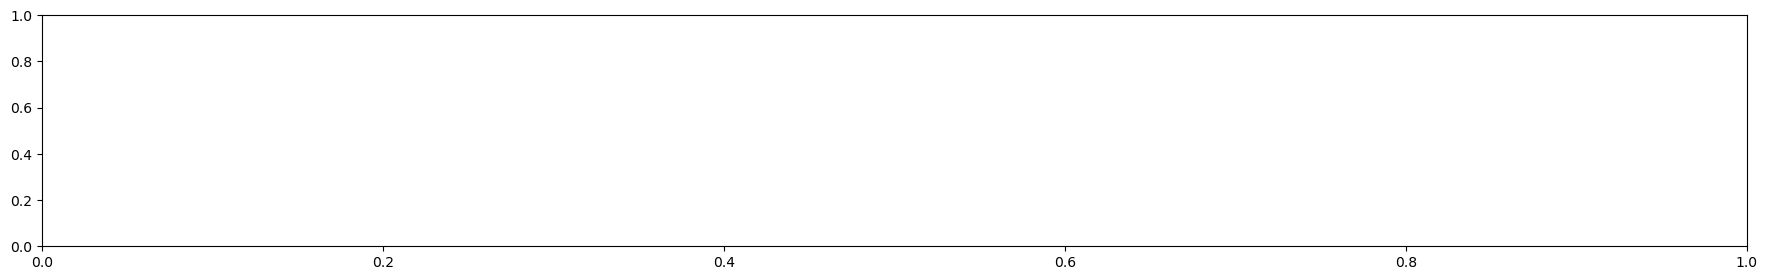

In [158]:
fig = plt.figure(figsize=(22,3))
ax = fig.add_subplot()

# using indexing to select gronigen and the daily number of cases
m_day_ts_plot = ax.plot(m_day_results_ts['lost_theatre_slots'])
ax.set_title('Lost theatre slots across model runtime (175 days)')

# summary results per day for multiple runs  

## Group by weekday

In [27]:
m_day_results_wd = m_day_results.groupby(['weekday']).mean()
m_day_results_wd.head()

,sim_time,bed_utilisation,lost_theatre_slots,primary_arrivals,revision_arrivals,primary_bed_queue,revision_bed_queue,primary_mean_los,revision_mean_los,run
weekday,,,,,,,,,,
0,57.0,0.921333,0.625036,12.400000,3.800000,0.012558,0.044524,9.209467,7.778600,5.5
1,54.5,0.914821,0.629764,12.000000,4.000000,0.012800,0.044847,9.204357,7.771714,5.5
2,55.5,0.920357,0.632605,10.857143,4.571429,0.013104,0.045908,9.203143,7.764286,5.5
3,56.5,0.920357,0.636272,11.285714,4.357143,0.013359,0.047413,9.197000,7.762643,5.5
4,57.5,0.932857,0.640665,12.857143,3.571429,0.013580,0.048736,9.192929,7.762786,5.5


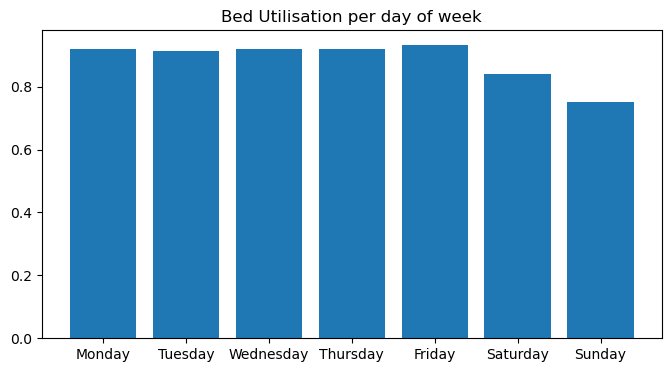

In [28]:
values = m_day_results_wd['bed_utilisation']
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
m_day_wd_plot = ax.bar(names, values)
#m_day_wd_plot = ax.plot(m_day_results_wd['bed_utilisation'] )
ax.set_title('Bed Utilisation per day of week')
plt.savefig('Bed Utilisation example output')

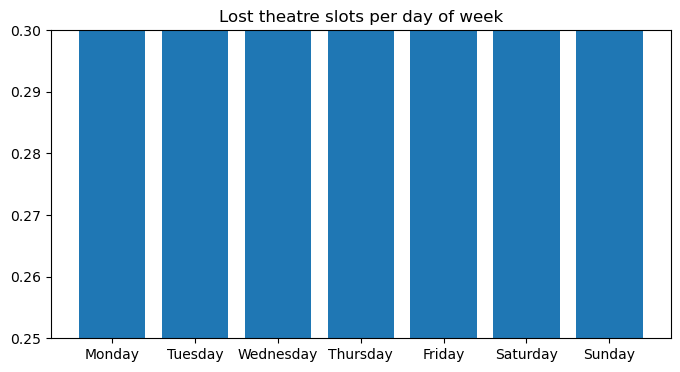

In [29]:
values = m_day_results_wd['lost_theatre_slots']
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
m_day_wd_plot = ax.bar(names, values)
ax.set_title('Lost theatre slots per day of week')
ax.set_ybound(lower = 0.25, upper = 0.3)
plt.savefig('Lost theatre slots example')

## MORE plots as per TM

In [30]:
#calc means of multiple reps by rep
more_plot_results = m_day_results.groupby(['run']).mean()
more_plot_results_ = more_plot_results.loc[:, ['bed_utilisation', 'lost_theatre_slots', 'primary_bed_queue', 'revision_bed_queue']] 
more_plot_results_ = more_plot_results_.reset_index(drop=True)


more_plot_results_ *= 100
more_plot_results_.columns = [0,1,2,3]
more_plot_results_.index.name = None

more_plot_results_.head()

,0,1,2,3
0,88.425,63.106528,1.044811,6.601416
1,87.925,63.915481,0.811230,6.508619
2,88.325,63.742251,1.604947,4.538197
3,88.300,63.815414,1.074310,2.975775
4,88.950,62.872303,1.604183,1.639458


In [31]:
def ci_for_sample_mean(mean_value, std, n, critical_value=1.96):
    '''Confidence interval for mean.  Assume std is sample std.
    
    Notes:
    ------
    
    critical value hard coded at the moment.  
    Should update to use t dist.
    '''
    half_width = (critical_value * (std / np.sqrt(n)))
    mean_lower = mean_value - half_width
    mean_upper = mean_value + half_width
    return mean_lower, mean_upper

def ci_percentile(results, field, percentile, critical_value=1.96):
    '''Approximate confidence interval for percentile.
    Note these may or may not be symmetric.
    
    Notes:
    ------
    
    critical value hard coded at the moment.  
    Should update to use t dist.
    
    Params:
    ------
    results: pd.DataFrame
        Results dataframe - tabular data where each row is a rep and each col is a KPI
        
    field: int
        Field from data frame to analyse
        
    percentile: float
        The percentile around which to form the CI
        
    critical_value: float, optional (default = 1.96)
        critical value of the normal dist to use.
    '''
    half_width = critical_value * np.sqrt((percentile * (1 - percentile)) / (len(results) - 1))
    y_beta_1 = results[field].quantile(percentile - half_width)
    y_beta_2 = results[field].quantile(percentile + half_width)
    return y_beta_1, y_beta_2

def as_horizontal_axis_fraction(value, xmin, xmax):
    '''Convert a axis value to a fraction accounting for the 
    minimum on the xaxis (i.e. axis may not start from 0).
    '''
    return (value - xmin) / (xmax - xmin)

def draw_interval(ax, start, end, style="|-|", lw=3, color='b'):
    '''Annotate a matplotlib chart underneath x axis with an confidence interval.
    '''
    _ = ax.annotate('', xy=(start, -0.1), xycoords='axes fraction', 
                       xytext=(end, -0.1),
                       arrowprops=dict(arrowstyle=style, color=color, lw=lw))

In [32]:
def more_plot(results, field=0, bins=None, figsize=(8, 5), percentiles=(0.05, 0.95), surpress_warnings=False):
    '''Measure of Risk and Error (MORE) plot.
    
    Risk illustrated via likely and unlikely ranges of replication values. 
    Erorr illustrated for CIs for mean and wide approx confidence intervals for percentiles
        
    Confidence intervals for percentiles will only be calculated if > 80 replications due to 
    approximation accuracy.
    
    Notes:
    ------
    Each value plotted represents the mean of a replication (e.g. daily throughput).  It should
    not be confused with an individuals results (e.g. an individuals throughput time). 
    
    If the system modelled contains time dependency the MORE plot may hide time of day/event effects.
    
    Params:
    ------
    results: pd.DataFrame
        Tabular data of replications. each column is a kpi
        
    field: int
        ID of column containing relevant data
        
    bins: int, optional (default=None)
        no. bins to generate. None=pandas decides no.
        
    figsize: tuple, optional (default=(8,5))
        size of plot
        
    
    Returns:
    -------
    fig, ax
    
    Refs:
    -----
    
    Nelson 2008. (Winter Simulation Paper)
    https://ieeexplore.ieee.org/document/4736095    
    
    '''
    
    # probably will shift these to module level scope.
    LIKELY = 'LIKELY'
    UNLIKELY = 'UNLIKELY'
    FONT_SIZE = 12
    LINE_WIDTH = 3
    LINE_STYLE = '-'
    CRIT_VALUE = 1.96
    UPPER_QUANTILE = percentiles[1]
    LOWER_QUANTILE = percentiles[0]
    INTERVAL_LW = 2
    MIN_N_FOR_PERCENTILE = 80
    WARN = f'CIs for percentiles are not generated as sample size < {MIN_N_FOR_PERCENTILE}.'
    WARN += ' To supress this msg set `supress_warnings=True`'

    ax = results[field].hist(bins=bins, figsize=figsize)
    mean = results[field].mean()
    std = results[field].std(ddof=1)
    upper_percentile = results[field].quantile(UPPER_QUANTILE)
    lower_percentile = results[field].quantile(LOWER_QUANTILE)

    # vertical lines
    ax.axvline(x=mean, linestyle='-', color='black', linewidth=LINE_WIDTH)
    ax.axvline(x=upper_percentile, linestyle='-', color='red', linewidth=LINE_WIDTH)
    ax.axvline(x=lower_percentile, linestyle='-', color='red', linewidth=LINE_WIDTH)

    like_font = {'family': 'serif',
                 'color':  'black',
                 'weight': 'bold',
                 'size': FONT_SIZE
                 }
    unlike_font = {'family': 'serif',
                 'color':  'red',
                 'weight': 'bold',
                 'size': FONT_SIZE
                 }

    # add text
    txt_offset = ax.get_ylim()[1] * 1.05
    ax.text(mean - (mean * 0.001), txt_offset, LIKELY, fontdict=like_font)
    ax.text(upper_percentile, txt_offset, UNLIKELY, fontdict=unlike_font)
    ax.text(ax.get_xlim()[0], txt_offset, UNLIKELY, fontdict=unlike_font)

    # calculate and display confidence intervals

    ## CIs for sample mean
    mean_lower, mean_upper = ci_for_sample_mean(mean, std, len(results))
    
    # Draw Confidence intervals
    # The horizontal lines are expressed as an axis fraction i.e. between 0 and 1.  
    # This means thatthe percentile CIs need to be converted before plotting.
    # The function as_horizontal_axis_fraction is used.

    ## mean CI  
    hline_mean_from = as_horizontal_axis_fraction(mean_lower, ax.get_xlim()[0], ax.get_xlim()[1])
    hline_mean_to = as_horizontal_axis_fraction(mean_upper, ax.get_xlim()[0], ax.get_xlim()[1])
    draw_interval(ax, hline_mean_from, hline_mean_to, lw=INTERVAL_LW)
    
    # avoid approximation issues with small samples.  
    if len(results) >= MIN_N_FOR_PERCENTILE:
        ## upper percentile
        y_beta_1, y_beta_2 = ci_percentile(results, field, UPPER_QUANTILE, critical_value=CRIT_VALUE)

        ## lower percentile
        y_beta_l_1, y_beta_l_2 = ci_percentile(results, field, LOWER_QUANTILE, critical_value=CRIT_VALUE)
        
        ## line for upper quantile CI
        hline_upper_q_from = (y_beta_1 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        hline_upper_q_to = (y_beta_2 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        
        hline_upper_q_from = as_horizontal_axis_fraction(y_beta_1, ax.get_xlim()[0], ax.get_xlim()[1])
        hline_upper_q_to = as_horizontal_axis_fraction(y_beta_2, ax.get_xlim()[0], ax.get_xlim()[1])
        draw_interval(ax, hline_upper_q_from, hline_upper_q_to, lw=INTERVAL_LW)
        
        ## line for lower quantile CI
        hline_lower_q_from = (y_beta_l_1 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        hline_lower_q_to = (y_beta_l_2 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        
        hline_lower_q_from = as_horizontal_axis_fraction(y_beta_l_1, ax.get_xlim()[0], ax.get_xlim()[1])
        hline_lower_q_to = as_horizontal_axis_fraction(y_beta_l_2, ax.get_xlim()[0], ax.get_xlim()[1])
        draw_interval(ax, hline_lower_q_from, hline_lower_q_to, lw=INTERVAL_LW)
        
    elif not surpress_warnings:
        warnings.warn(WARN)
        
    
    return ax.figure, ax

/tmp/ipykernel_187566/625959835.py:126: UserWarning: CIs for percentiles are not generated as sample size < 80. To supress this msg set `supress_warnings=True`
  warnings.warn(WARN)


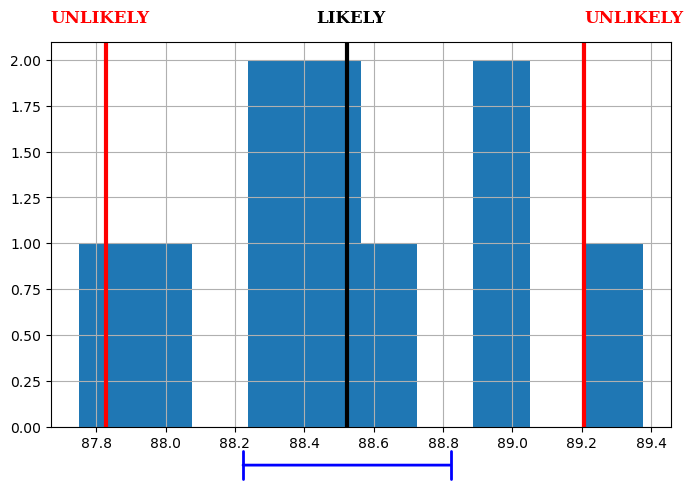

In [33]:
results = more_plot_results_

fig, ax = more_plot(results)

## hists of outputs

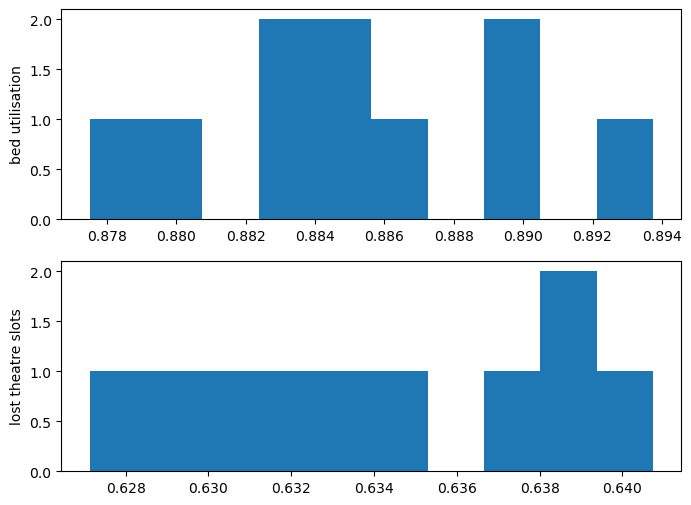

In [34]:
more_plot_results = m_day_results.groupby(['run']).mean()
hist_results = more_plot_results.loc[:, ['bed_utilisation', 'lost_theatre_slots']] 

fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].hist(hist_results['bed_utilisation']);
ax[0].set_ylabel('bed utilisation')
ax[1].hist(hist_results['lost_theatre_slots']);
ax[1].set_ylabel('lost theatre slots');


In [35]:
arr = [2, 0, 0, 0, 0, 12, 0, 8]
nParr = np.array(arr)
nParr.size

8

In [36]:
n=False*1
n

0

In [37]:
n=False
n

False